In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
#from fancyimpute import KNN, NuclearNormMinimization, SoftImpute, BiScaler
from sklearn.ensemble import IsolationForest
from sklearn import preprocessing
import calendar
import time

print("Importing data:",time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime()))
data = pd.read_csv("C:/Users/Simonas/Desktop/Projects/Useful/Python/2020_11_SEB_challange/GIT/Data/full.csv")
local_test_data = pd.read_csv("C:/Users/Simonas/Desktop/Projects/Useful/Python/2020_11_SEB_challange/GIT/Data/test_data_1.csv")

print("Done:",time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime()))
data.info()
#local_test_data.info()

Importing data: 2022-09-07 10:51:01
Done: 2022-09-07 10:51:19
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000000 entries, 0 to 9999999
Data columns (total 17 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   id                            int64  
 1   y                             int64  
 2   amount_current_loan           int64  
 3   term                          object 
 4   credit_score                  object 
 5   loan_purpose                  object 
 6   yearly_income                 float64
 7   home_ownership                object 
 8   bankruptcies                  float64
 9   years_current_job             float64
 10  monthly_debt                  float64
 11  years_credit_history          int64  
 12  months_since_last_delinquent  float64
 13  open_accounts                 int64  
 14  credit_problems               int64  
 15  credit_balance                int64  
 16  max_open_credit               float64
dtypes:

### Categoric variables - how many categories - are there any differences between test and train sets? We need to know the amount of categories in order to use one-hot-encoding

In [2]:
for column in data:
    if data[column].dtype == "object":
        print(column)
        print(data[column].unique())
        print(len(data[column].unique()))
        print(set(data[column].unique()).difference(set(local_test_data[column].unique())))
        print(set(local_test_data[column].unique()).difference(set(data[column].unique())))
       
        print("")

term
['short' 'long']
2
set()
set()

credit_score
['very_good' 'good' nan 'fair']
4
set()
set()

loan_purpose
['other' 'debt_consolidation' 'home_improvements' 'take_a_trip'
 'medical_bills' 'educational_expenses' 'major_purchase' 'small_business'
 'business_loan' 'buy_a_car' 'moving' 'buy_house' 'vacation' 'wedding'
 'renewable_energy' 'UFVCU1VC']
16
{'UFVCU1VC', 'renewable_energy'}
set()

home_ownership
['rent' 'mortgage' 'own']
3
set()
set()



### How many missing values are there for each column? (for now further analysing only train data set)

In [4]:
##########################################################################
## Missing values - how much are we missing?
def count_empty_rows_by_features(data_set):
  for i in range(data_set.shape[1]):
    # count number of rows with missing values
    n_miss = data_set.iloc[:,i].isnull().sum()
    perc = n_miss / data_set.shape[0] * 100
    print('> %s,\t\tMissing:\t%d (%.1f%%)' % (data_set.columns[i], n_miss, perc))  

#print("test data:")
#count_empty_rows_by_features(local_test_data)
    
print('*********************************************************************************************')
print("full data:")
count_empty_rows_by_features(data)

*********************************************************************************************
full data:
> id,		Missing:	0 (0.0%)
> y,		Missing:	0 (0.0%)
> amount_current_loan,		Missing:	0 (0.0%)
> term,		Missing:	0 (0.0%)
> credit_score,		Missing:	2377778 (23.8%)
> loan_purpose,		Missing:	0 (0.0%)
> yearly_income,		Missing:	1919747 (19.2%)
> home_ownership,		Missing:	0 (0.0%)
> bankruptcies,		Missing:	18354 (0.2%)
> years_current_job,		Missing:	422327 (4.2%)
> monthly_debt,		Missing:	0 (0.0%)
> years_credit_history,		Missing:	0 (0.0%)
> months_since_last_delinquent,		Missing:	5317819 (53.2%)
> open_accounts,		Missing:	0 (0.0%)
> credit_problems,		Missing:	0 (0.0%)
> credit_balance,		Missing:	0 (0.0%)
> max_open_credit,		Missing:	192 (0.0%)


* credit_score (categorical) - 23.8% missing - could be assumed that these debtors have no credit history?
* yearly_income - 19.2% missing - could be a fault in data set? or not employed people?
* bankruptcies - 0.2% missing - possible error in data (no bankruptcies result in "0")
* years_current_job - 4.2% missing - also possible error in data (no years in job would be "0")
* months_since_last_delinquent - 53.2% missing - possible that these are debtors with no historical delinquent

#### Drop rows with a lot of NAs (other NAs will be filled)

In [6]:
data_cleaning = data.copy()

In [7]:
###############################################################
### Drop rows which are empty in all 3 columns: credit_score, months_since_last_delinquent,yearly_income
print("Data before drop:", np.shape(data_cleaning))

data_cleaning.drop(data_cleaning[(data_cleaning['credit_score'].isna()) 
     & (data_cleaning['months_since_last_delinquent'].isna()) 
     & (data_cleaning['yearly_income'].isna())].index, inplace=True)

print("Data after drop:", np.shape(data_cleaning))
count_empty_rows_by_features(data_cleaning)

Data before drop: (10000000, 17)
Data after drop: (8948911, 17)
> id,		Missing:	0 (0.0%)
> y,		Missing:	0 (0.0%)
> amount_current_loan,		Missing:	0 (0.0%)
> term,		Missing:	0 (0.0%)
> credit_score,		Missing:	1326689 (14.8%)
> loan_purpose,		Missing:	0 (0.0%)
> yearly_income,		Missing:	868658 (9.7%)
> home_ownership,		Missing:	0 (0.0%)
> bankruptcies,		Missing:	18316 (0.2%)
> years_current_job,		Missing:	379210 (4.2%)
> monthly_debt,		Missing:	0 (0.0%)
> years_credit_history,		Missing:	0 (0.0%)
> months_since_last_delinquent,		Missing:	4266730 (47.7%)
> open_accounts,		Missing:	0 (0.0%)
> credit_problems,		Missing:	0 (0.0%)
> credit_balance,		Missing:	0 (0.0%)
> max_open_credit,		Missing:	175 (0.0%)


In [8]:
###############################################################
######### Remove other NA rows
print("Data before drop:", np.shape(data_cleaning))

data_cleaning.drop(data_cleaning[data_cleaning["max_open_credit"].isnull()].index, inplace = True) 
data_cleaning.drop(data_cleaning[data_cleaning["bankruptcies"].isnull()].index, inplace = True) 
data_cleaning.drop(data_cleaning[data_cleaning["years_current_job"].isnull()].index, inplace = True) 

data_cleaning['credit_score'] = data_cleaning['credit_score'].fillna('unknown')

print("Data after drop:", np.shape(data_cleaning))
count_empty_rows_by_features(data_cleaning)

Data before drop: (8948911, 17)
Data after drop: (8551891, 17)
> id,		Missing:	0 (0.0%)
> y,		Missing:	0 (0.0%)
> amount_current_loan,		Missing:	0 (0.0%)
> term,		Missing:	0 (0.0%)
> credit_score,		Missing:	0 (0.0%)
> loan_purpose,		Missing:	0 (0.0%)
> yearly_income,		Missing:	826577 (9.7%)
> home_ownership,		Missing:	0 (0.0%)
> bankruptcies,		Missing:	0 (0.0%)
> years_current_job,		Missing:	0 (0.0%)
> monthly_debt,		Missing:	0 (0.0%)
> years_credit_history,		Missing:	0 (0.0%)
> months_since_last_delinquent,		Missing:	4085501 (47.8%)
> open_accounts,		Missing:	0 (0.0%)
> credit_problems,		Missing:	0 (0.0%)
> credit_balance,		Missing:	0 (0.0%)
> max_open_credit,		Missing:	0 (0.0%)


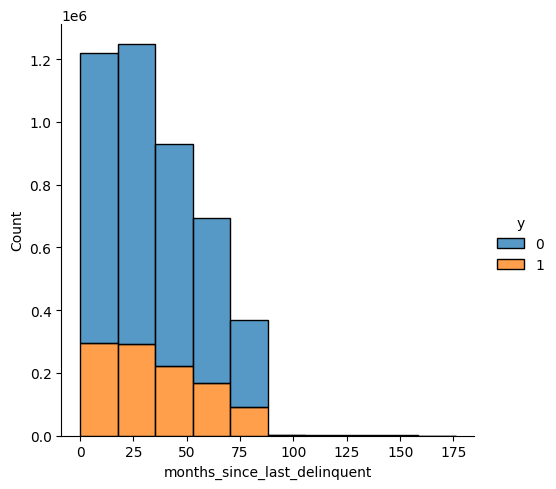

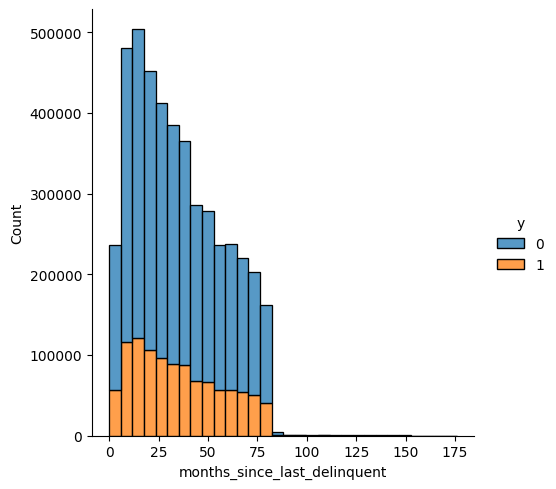

In [17]:
sns.displot(data_cleaning, x="months_since_last_delinquent", bins=10, hue='y', multiple="stack")
sns.displot(data_cleaning, x="months_since_last_delinquent", bins=30, hue='y', multiple="stack")

## Check data characteristics, any outliers?

In [9]:
data_processing_outliers = data_cleaning

In [10]:
data_processing_outliers.iloc[:,2:].describe().apply(lambda s: s.apply('{0:.2f}'.format))

,amount_current_loan,yearly_income,bankruptcies,years_current_job,monthly_debt,years_credit_history,months_since_last_delinquent,open_accounts,credit_problems,credit_balance,max_open_credit
count,8551891.00,7725314.00,8551891.00,8551891.00,8551891.00,8551891.00,4466390.00,8551891.00,8551891.00,8551891.00,8551891.00
mean,13183033.73,1399248.44,0.11,5.92,18779.55,18.11,34.96,11.23,0.17,297849.99,764018.74
std,33422291.03,1146318.12,0.35,3.63,12223.51,6.82,21.99,5.05,0.49,379677.46,7593513.04
min,10802.00,76627.00,0.00,0.00,0.00,4.00,0.00,0.00,0.00,0.00,0.00
25%,187880.00,862277.00,0.00,3.00,10511.94,14.00,16.00,8.00,0.00,113259.00,276056.00
50%,323598.00,1202510.00,0.00,6.00,16524.68,17.00,32.00,10.00,0.00,210653.00,471064.00
75%,540386.00,1678308.00,0.00,10.00,24323.42,22.00,51.00,14.00,0.00,370063.00,789316.00
max,99999999.00,165557393.00,7.00,10.00,435843.28,70.00,176.00,76.00,15.00,32878968.00,1539737892.00


In [11]:
### Interesting find:
len(data_processing_outliers[data_processing_outliers["amount_current_loan"] == 99999999])

1103813

###### There are quite a lot of records (~13%) with "amount_current_loan" value of 99999999.00? Needs to be investigated further.
###### Proceed with outlier fixing

In [12]:
def draw_boxplots(df):       
    data_checking_outliers_int_float = df.select_dtypes([int, float])
    for i, col in enumerate(data_checking_outliers_int_float.columns):
        plt.figure(i)
        sns.boxplot(x=data_checking_outliers_int_float[col])
        
def mark_outlier(row,column,ul,ll):  
    if row[column] > ul or row[column] < ll:
        return 1
    return 0

def identify_outlier_IQR(df, column):
    df_final = df
    Q1=df[column].quantile(0.25)
    Q3=df[column].quantile(0.75)
    IQR=Q3-Q1
    ul = Q3+1.5*IQR
    ll = Q1-1.5*IQR    
    df_final['is_outlier'] = df_final.apply(lambda row: mark_outlier(row,column,ul,ll), axis=1)
    return df_final       

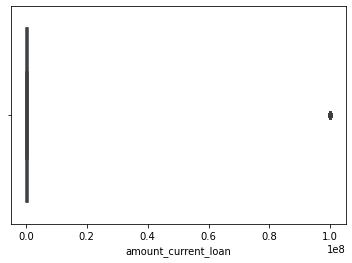

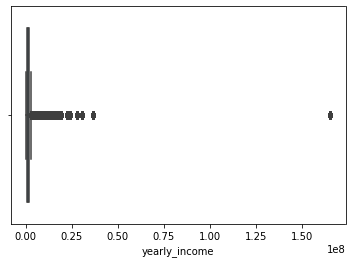

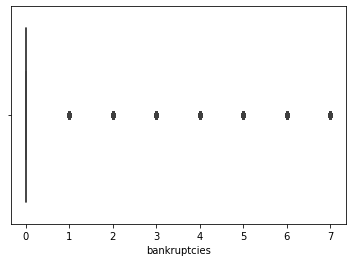

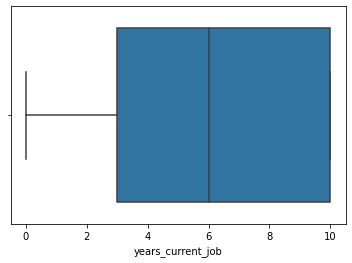

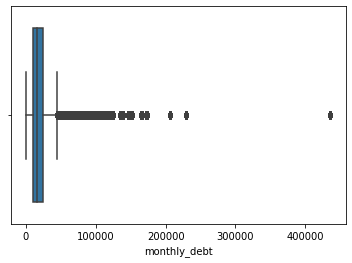

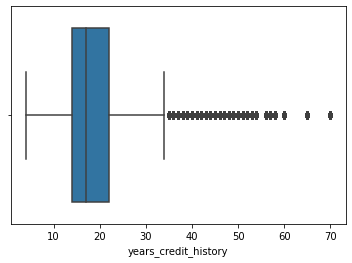

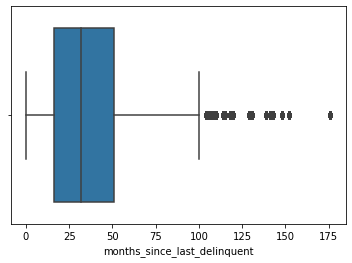

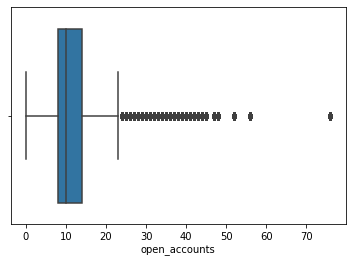

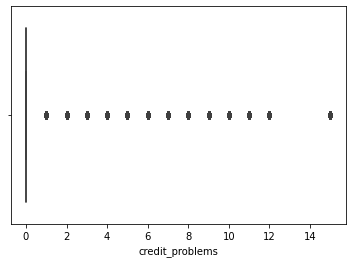

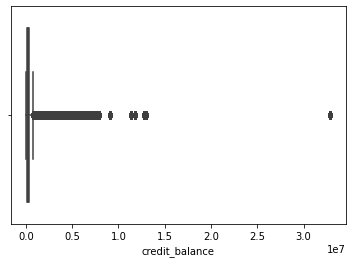

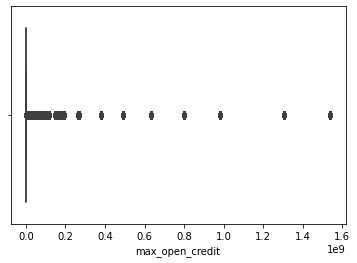

In [13]:
draw_boxplots(data_processing_outliers.iloc[:,2:])

### IQR method

"If there's too much skewness in the data, then many statistical models don't work effectively. Why is that? In skewed data, the tail region may act as an outlier for the statistical model, and we know that outliers adversely affect a model's performance, especially regression-based models."

"If the skewness is between -0.5 and 0.5, the data are fairly symmetrical. If the skewness is between -1 and – 0.5 or between 0.5 and 1, the data are moderately skewed. If the skewness is less than -1 or greater than 1, the data are highly skewed."

In [15]:
data_outliers_only = pd.DataFrame()
for column in ['amount_current_loan', 'yearly_income', 'monthly_debt', 'credit_balance', 'max_open_credit']:
    print(column,"- start time:",time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime()))
    data_col_identified_outliers = identify_outlier_IQR(data_processing_outliers, column)
    data_col_without_outliers = data_col_identified_outliers[data_col_identified_outliers['is_outlier'] == 0]
    data_col_outliers_new = data_col_identified_outliers[data_col_identified_outliers['is_outlier'] == 1]
    data_outliers_only = pd.concat([data_outliers_only, data_col_outliers_new], ignore_index=True)
    print('No outliers:', len(data_col_without_outliers), ' column mean:',round(data_col_without_outliers[column].mean(),2))
    print('Outliers:', len(data_col_outliers_new), ' column mean:',round(data_col_outliers_new[column].mean(),2))
    print(column,"- skew before -",data_processing_outliers[column].skew())    
    print(column,"- skew after -",data_col_without_outliers[column].skew())
    print(" ")
    data_processing_outliers = data_col_without_outliers.drop("is_outlier", axis=1)


data_processing_outliers.info()

amount_current_loan - start time: 2022-09-07 10:54:24
No outliers: 7448078  column mean: 316668.08
Outliers: 1103813  column mean: 99999999.0
amount_current_loan - skew before - 2.2125215389300066
amount_current_loan - skew after - 0.7386054023639558
 
yearly_income - start time: 2022-09-07 10:56:02
No outliers: 7145459  column mean: 1258560.13
Outliers: 302619  column mean: 4230632.59
yearly_income - skew before - 58.172425960652106
yearly_income - skew after - 0.7302093802677023
 
monthly_debt - start time: 2022-09-07 10:57:32
No outliers: 6964721  column mean: 17087.07
Outliers: 180738  column mean: 51762.05
monthly_debt - skew before - 1.1416361908847998
monthly_debt - skew after - 0.5411977625707447
 
credit_balance - start time: 2022-09-07 10:59:00
No outliers: 6641512  column mean: 226428.17
Outliers: 323209  column mean: 1040980.49
credit_balance - skew before - 4.907793561946186
credit_balance - skew after - 0.8644105796701371
 
max_open_credit - start time: 2022-09-07 11:00:2

In [16]:
print(len(data_processing_outliers))
print(len(data_outliers_only))

6385546
2166345


Big chunk of data was considered as outliers - it would make sense to evaluate outliers separately or:
1) Evaluate primary data iteratevily until certain (selected) skewness is reached

2) Use other outlier detection methods

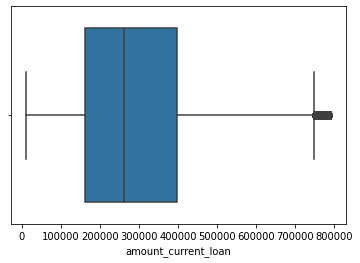

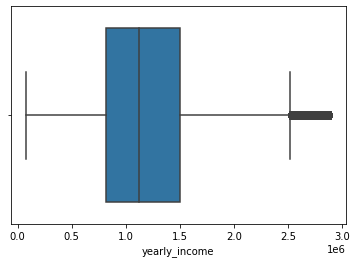

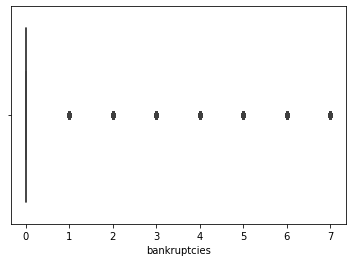

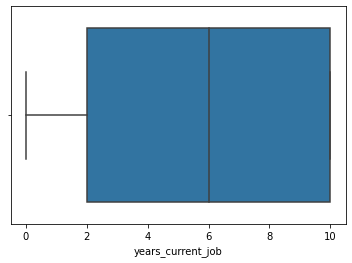

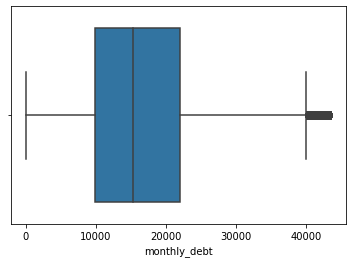

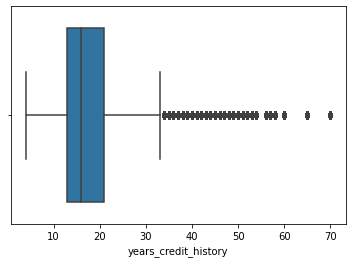

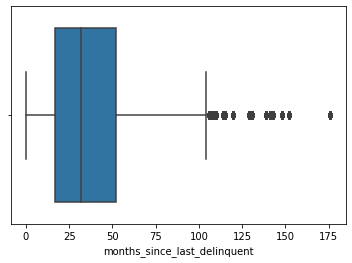

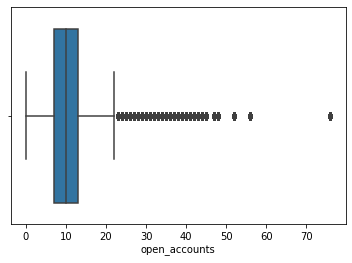

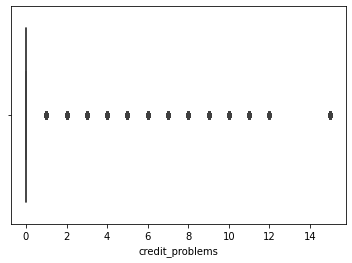

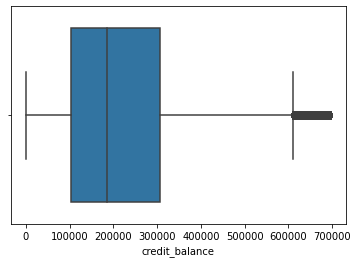

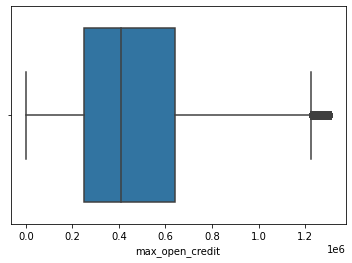

In [27]:
draw_boxplots(data_processing_outliers.iloc[:,2:])

### A lot more to be done....

For now this method is not used

In [17]:
data_temp = data_processing_outliers.copy()

amount_current_loan - skew before - 2.2125215389300066
To be dropped: 1531417 New data size: 7020474
amount_current_loan - skew after - 0.7920274785552978
 
yearly_income - skew before - 58.49603140819228
To be dropped: 624136 New data size: 6396338
yearly_income - skew after - 0.798672019636077
 
monthly_debt - skew before - 1.1291830518922568
To be dropped: 639659 New data size: 5756679
monthly_debt - skew after - 0.4770899602468715
 
credit_balance - skew before - 4.7596528714895
To be dropped: 575689 New data size: 5180990
credit_balance - skew after - 0.8209314385723816
 
max_open_credit - skew before - 285.4735073551464
To be dropped: 518300 New data size: 4662690
max_open_credit - skew after - 0.722779887295793
 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4662690 entries, 0 to 9999997
Data columns (total 17 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   id                            int64  
 1   y                      

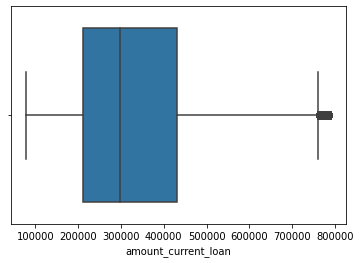

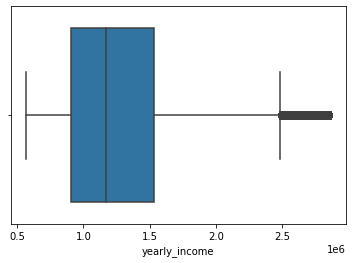

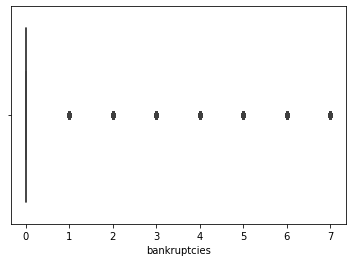

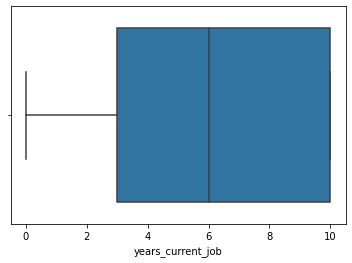

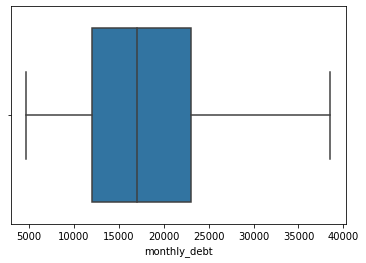

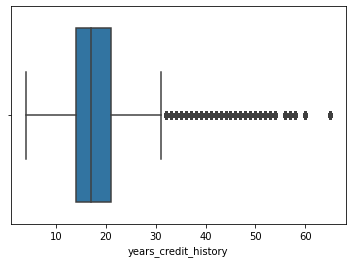

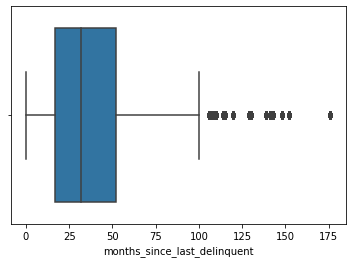

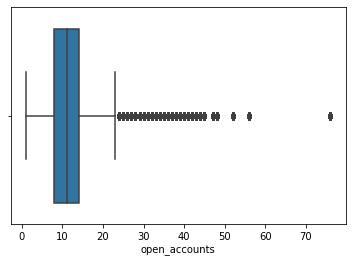

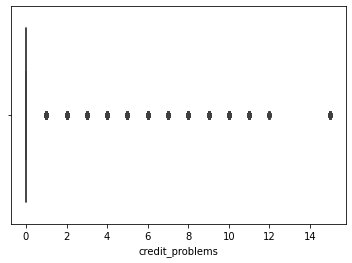

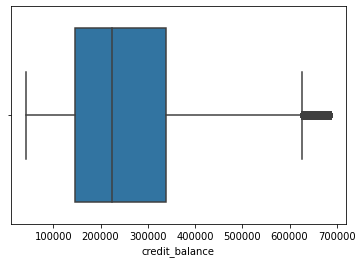

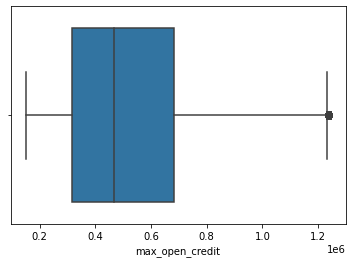

In [55]:
#### ANOTHER WAY OF DROPPING OUTLIERS - NOT SO EFFECTIVE THOUGH (drops a lot of data, the resulting skew is similiar to IQR)
#for col in ['amount_current_loan', 'yearly_income', 'monthly_debt', 'credit_balance', 'max_open_credit']:
#    print(col,"- skew before -",data_temp[col].skew())
#    outliers_index = data_temp[(data_temp[col] >= data_temp[col].quantile(0.95))|(data_temp[col] <= (data_temp[col].quantile(0.05)))].index
#    print("To be dropped:",len(outliers_index), "New data size:",len(data_temp)-len(outliers_index))
#    data_temp.drop(outliers_index, inplace=True, axis=0)
#    print(col,"- skew after -",data_temp[col].skew())
#    print(" ")
#
#data_temp.info()
#
#draw_boxplots(data_temp.iloc[:,2:])

In [31]:
data_processing_outliers = data_temp

## Aggregate categories and analyse

As a lot of methods do not handle categorical variables, that's why One Hot Encoding will be used (create a column for every category there is).
To reduce the amount of columns created, some categories will be combined (based on similiar characteristics).

In [19]:
data_aggregate = data_processing_outliers

In [20]:
def categories_info(data, cat_column):
    
    cats_without_nans = [x for x in data[cat_column].unique() if str(x) != 'nan']
    
    d = pd.DataFrame(columns = ['category', 'ratio_to_data(%)', 'good_loans', 'bad_loans', 'good_bad_ratio(%)'])
    
    for cat in sorted(cats_without_nans):
        cat_rows = data[data[cat_column] == cat]
        d.loc[d.shape[0]] = [cat,
                            round(cat_rows.shape[0]/data.shape[0]*100,4),
                            cat_rows[cat_rows["y"] == 0].shape[0], 
                            cat_rows[cat_rows["y"] == 1].shape[0],
                            round((cat_rows[cat_rows["y"] == 0].shape[0]/cat_rows.shape[0]*100), 4)]
    #return d.sort_values('ratio_to_data(%)')
    return d.sort_values('good_bad_ratio(%)')

In [21]:
########################################################
###### As some information can be received from deliquent data - try to leave it
###### Trying to imput the data might be risky - might disrupt the data, we can tighten it
BIN_FREQUENCY_MONTHS = 12
LAST_NUM_OF_MONTHS = 72
temp_bins = list(range(0, LAST_NUM_OF_MONTHS, BIN_FREQUENCY_MONTHS))
temp_bins.append(999)
print(len(temp_bins))
print(temp_bins)

temp_labels = ['M' + str(n) for n in range(BIN_FREQUENCY_MONTHS, LAST_NUM_OF_MONTHS, BIN_FREQUENCY_MONTHS)] + ['More']
print(len(temp_labels))
print(temp_labels)


data_aggregate['delinquent_cat'] = pd.cut(x=data_aggregate['months_since_last_delinquent'], 
                     bins=temp_bins,
                     labels=temp_labels)

data_aggregate["delinquent_cat"] = data_aggregate["delinquent_cat"].cat.add_categories("Other")
data_aggregate["delinquent_cat"] = data_aggregate["delinquent_cat"].fillna("Other")

data_aggregate = data_aggregate.drop(['months_since_last_delinquent'], axis=1)

7
[0, 12, 24, 36, 48, 60, 999]
6
['M12', 'M24', 'M36', 'M48', 'M60', 'More']


In [22]:
########################################################
###### ANALYSIS OF CATEGORIES

category_analysis = {}
for column in data_aggregate:
    if data_aggregate[column].dtype in ["object", "category"]:
        category_analysis[column] = categories_info(data_aggregate, column)
        display(category_analysis[column].style.set_caption(column))
        #sns.displot(data_aggregate, x=column, bins=10, hue='y', multiple="stack")
        print(' ')

,category,ratio_to_data(%),good_loans,bad_loans,good_bad_ratio(%)
0,long,28.452200,1165365,651462,64.142900
1,short,71.547800,3470243,1098476,75.956600


,category,ratio_to_data(%),good_loans,bad_loans,good_bad_ratio(%)
2,unknown,17.487400,527024,589639,47.196300
0,fair,6.179000,263732,130834,66.841000
1,good,60.068500,2959641,876058,77.160400
3,very_good,16.265100,885211,153407,85.229700


,category,ratio_to_data(%),good_loans,bad_loans,good_bad_ratio(%)
0,UFVCU1VC,0.000000,0,1,0.000000
12,small_business,0.273000,9903,7532,56.799500
1,business_loan,1.523400,64150,33130,65.943700
9,moving,0.145100,6148,3118,66.350100
7,major_purchase,0.339100,14414,7241,66.562000
14,vacation,0.108400,4714,2209,68.091900
8,medical_bills,1.101000,47983,22320,68.251700
11,renewable_energy,0.010500,466,207,69.242200
3,buy_house,0.657900,29471,12538,70.154000
15,wedding,0.113000,5087,2130,70.486400


,category,ratio_to_data(%),good_loans,bad_loans,good_bad_ratio(%)
2,rent,45.306600,2045979,847095,70.719900
1,own,8.894300,409937,158010,72.178700
0,mortgage,45.799100,2179692,744833,74.531500


,category,ratio_to_data(%),good_loans,bad_loans,good_bad_ratio(%)
5,More,9.258100,425025,166155,71.894300
6,Other,45.635700,2105526,808563,72.253300
0,M12,9.361300,435752,162021,72.895900
4,M60,5.982400,278512,103496,72.907400
3,M48,8.653200,403352,149205,72.997400
1,M24,11.418400,532596,196534,73.045400
2,M36,9.690800,454845,163964,73.503300


Some insights could be foremed here - loan_purpose, credit_score and term can help identify potential bad loans.

In [23]:
######################################################################
#### Based on above analysis, we can drop or contract some categories
data_aggregate.drop(data_aggregate[data_aggregate['loan_purpose'] == 'UFVCU1VC'].index, inplace = True)
data_aggregate.drop(data_aggregate[data_aggregate['loan_purpose'] == 'renewable_energy'].index, inplace = True)

data_aggregate['loan_purpose'] = data_aggregate['loan_purpose'].replace(['wedding', 'educational_expenses'], 'education&wedding')
data_aggregate['loan_purpose'] = data_aggregate['loan_purpose'].replace(['vacation', 'major_purchase', 'moving'], 'vacation&purch&move')

Some example graphs based on previous analysis

home_ownership       mortgage     own     rent
loan_purpose                                  
business_loan           44244    8098    44938
buy_a_car               29033    8038    39175
buy_house               13334    3979    24696
debt_consolidation    2286343  426029  2314997
education&wedding        3146     829     9698
home_improvements      265764   53012    31766
medical_bills           29489    7456    33358
other                  220396   52851   341737
small_business           7140    1609     8686
take_a_trip             13679    3153    20355
vacation&purch&move     11626    2868    23350


<AxesSubplot:xlabel='years_current_job'>

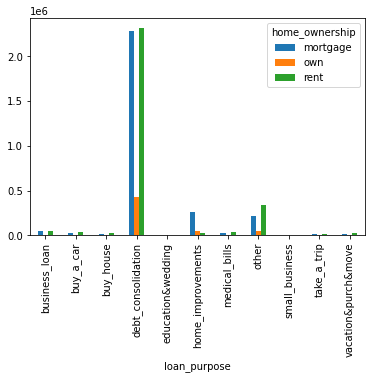

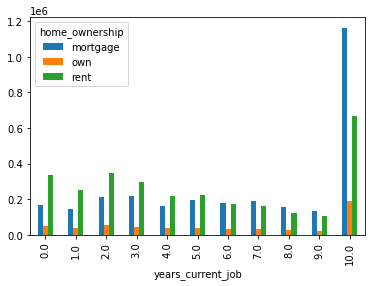

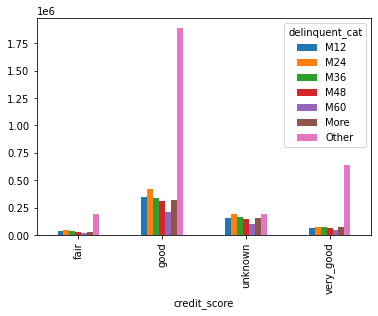

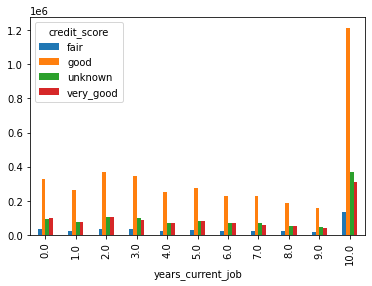

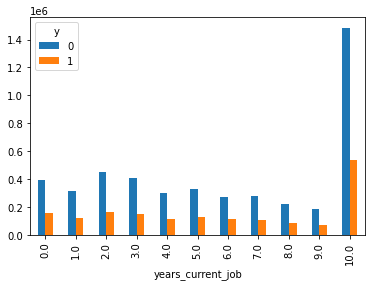

In [31]:
CrosstabResult=pd.crosstab(index=data_aggregate['loan_purpose'],columns=data_aggregate['home_ownership'])
CrosstabResult1=pd.crosstab(index=data_aggregate['years_current_job'],columns=data_aggregate['home_ownership'])
CrosstabResult2=pd.crosstab(index=data_aggregate['credit_score'],columns=data_aggregate['delinquent_cat'])
CrosstabResult3=pd.crosstab(index=data_aggregate['years_current_job'],columns=data_aggregate['credit_score'])
CrosstabResult4=pd.crosstab(index=data_aggregate['years_current_job'],columns=data_aggregate['y'])


print(CrosstabResult)

%matplotlib inline
CrosstabResult.plot.bar()
CrosstabResult1.plot.bar()
CrosstabResult2.plot.bar()
CrosstabResult3.plot.bar()
CrosstabResult4.plot.bar()

<AxesSubplot:xlabel='loan_purpose'>

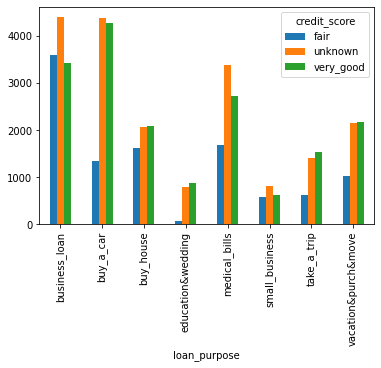

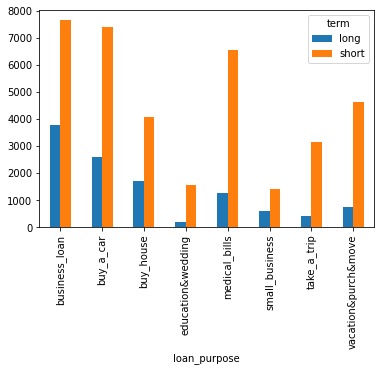

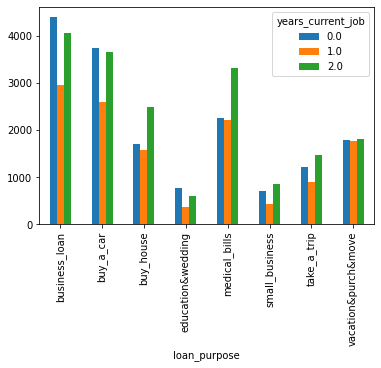

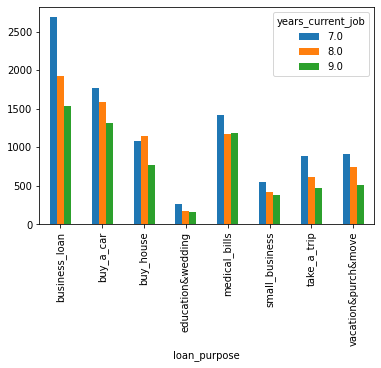

In [42]:
tempData_custom_slice = data_aggregate[(data_aggregate['loan_purpose'] != "debt_consolidation")
                                       & (data_aggregate['loan_purpose'] != "other")
                                       & (data_aggregate['loan_purpose'] != "home_improvements")
                                       & (data_aggregate['credit_score'] != "good")
                                       & (data_aggregate['years_current_job'] < 3)]

CrosstabResult=pd.crosstab(index=tempData_custom_slice['loan_purpose'],columns=tempData_custom_slice['credit_score'])
CrosstabResult1=pd.crosstab(index=tempData_custom_slice['loan_purpose'],columns=tempData_custom_slice['term'])
CrosstabResult2=pd.crosstab(index=tempData_custom_slice['loan_purpose'],columns=tempData_custom_slice['years_current_job'])

tempData_custom_slice = data_aggregate[(data_aggregate['loan_purpose'] != "debt_consolidation")
                                       & (data_aggregate['loan_purpose'] != "other")
                                       & (data_aggregate['loan_purpose'] != "home_improvements")
                                       & (data_aggregate['credit_score'] != "good")
                                       & (data_aggregate['years_current_job'] > 6)
                                       & (data_aggregate['years_current_job'] < 10)]

CrosstabResult3=pd.crosstab(index=tempData_custom_slice['loan_purpose'],columns=tempData_custom_slice['years_current_job'])


CrosstabResult.plot.bar()
CrosstabResult1.plot.bar()
CrosstabResult2.plot.bar()
CrosstabResult3.plot.bar()

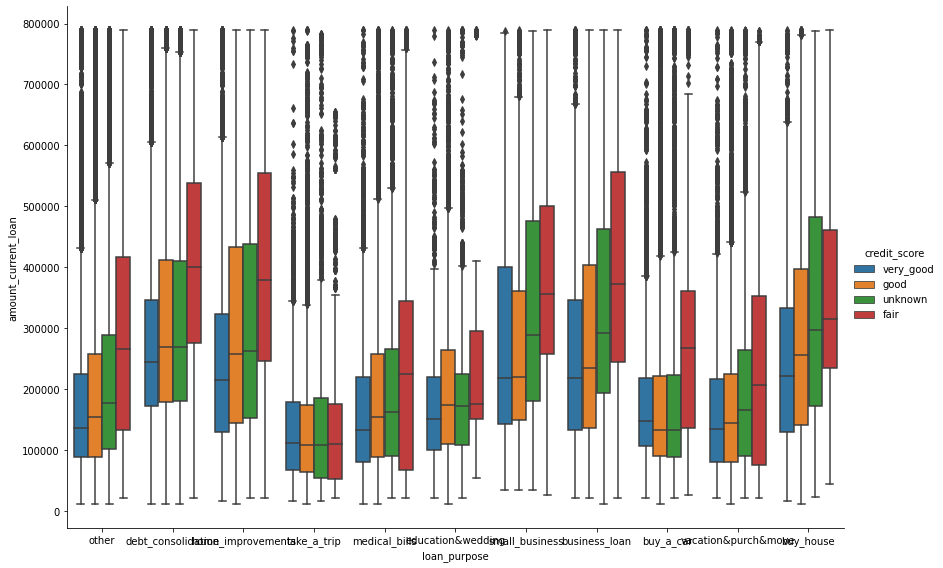

In [17]:
sns.catplot(x="loan_purpose", y="amount_current_loan", hue="credit_score", kind="box", data=data_aggregate, height=8, aspect=12/8)

A lot of custom data slices and representations could be done in order to better know the client. 

### Imputing missing yearly_income

In [43]:
def is_yearly_NA(row):  
    if pd.isnull(row['yearly_income']):
        return 1
    return 0

In [45]:
data_imputing = data_aggregate

In [46]:
##################################################################
## One-hot-encoding data to use for missing yerly_income inputation
data_ohe = pd.get_dummies(data_imputing)
data_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6384872 entries, 0 to 9999999
Data columns (total 39 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   id                                int64  
 1   y                                 int64  
 2   amount_current_loan               int64  
 3   yearly_income                     float64
 4   bankruptcies                      float64
 5   years_current_job                 float64
 6   monthly_debt                      float64
 7   years_credit_history              int64  
 8   open_accounts                     int64  
 9   credit_problems                   int64  
 10  credit_balance                    int64  
 11  max_open_credit                   float64
 12  term_long                         uint8  
 13  term_short                        uint8  
 14  credit_score_fair                 uint8  
 15  credit_score_good                 uint8  
 16  credit_score_unknown              ui

In [47]:
data_ohe_filled = data_ohe
num_rows_yi_nan_and_bad_loan = len(data_ohe_filled[data_ohe_filled["yearly_income"].isna() & data_ohe_filled["y"] == 1])
num_total_rows_yi_nan = len(data_ohe_filled[data_ohe_filled["yearly_income"].isna()])

print("Bad loans in yearly_income = missing:")
print(round((num_rows_yi_nan_and_bad_loan/num_total_rows_yi_nan),4))

print("Bad loans in total in all dataset:")
print(round(len(data_ohe_filled[data_ohe_filled["y"] == 1])/len(data_ohe_filled),4))

######################################################################################
# It is worth to remember which rows had no yearly income?

Bad loans in yearly_income = missing:
0.2896
Bad loans in total in all dataset:
0.274


Let's keep track of which records had missing yearly income

In [49]:
data_ohe_filled['yearly_income_NA'] = data_ohe_filled.apply(lambda row: is_yearly_NA(row), axis=1)

##### TEST #####
print(len(data_ohe_filled))
print(data_ohe_filled['yearly_income_NA'].sum())
print(len(data_ohe_filled[data_ohe_filled['yearly_income'].isna()]))
data_ohe_filled.head()

6384872
741791
741791


,id,y,amount_current_loan,yearly_income,bankruptcies,years_current_job,monthly_debt,years_credit_history,open_accounts,credit_problems,...,home_ownership_own,home_ownership_rent,delinquent_cat_M12,delinquent_cat_M24,delinquent_cat_M36,delinquent_cat_M48,delinquent_cat_M60,delinquent_cat_More,delinquent_cat_Other,yearly_income_NA
0,1,0,386342,1371971.0,0.0,4.0,5281.62,17,9,0,...,0,1,0,0,1,0,0,0,0,0
1,2,0,429000,823042.0,0.0,10.0,13854.61,19,15,0,...,0,0,1,0,0,0,0,0,0,0
4,5,0,654126,1242847.0,0.0,0.0,27490.15,28,8,1,...,0,1,0,0,0,0,0,1,0,0
5,6,0,133034,651035.0,0.0,10.0,6473.11,30,12,0,...,0,1,0,0,0,0,0,0,1,0
6,7,0,317570,1937601.0,0.0,10.0,34154.97,17,12,0,...,0,0,0,0,0,0,0,0,1,0


In [50]:
count_empty_rows_by_features(data_ohe_filled)

> id,		Missing:	0 (0.0%)
> y,		Missing:	0 (0.0%)
> amount_current_loan,		Missing:	0 (0.0%)
> yearly_income,		Missing:	741791 (11.6%)
> bankruptcies,		Missing:	0 (0.0%)
> years_current_job,		Missing:	0 (0.0%)
> monthly_debt,		Missing:	0 (0.0%)
> years_credit_history,		Missing:	0 (0.0%)
> open_accounts,		Missing:	0 (0.0%)
> credit_problems,		Missing:	0 (0.0%)
> credit_balance,		Missing:	0 (0.0%)
> max_open_credit,		Missing:	0 (0.0%)
> term_long,		Missing:	0 (0.0%)
> term_short,		Missing:	0 (0.0%)
> credit_score_fair,		Missing:	0 (0.0%)
> credit_score_good,		Missing:	0 (0.0%)
> credit_score_unknown,		Missing:	0 (0.0%)
> credit_score_very_good,		Missing:	0 (0.0%)
> loan_purpose_business_loan,		Missing:	0 (0.0%)
> loan_purpose_buy_a_car,		Missing:	0 (0.0%)
> loan_purpose_buy_house,		Missing:	0 (0.0%)
> loan_purpose_debt_consolidation,		Missing:	0 (0.0%)
> loan_purpose_education&wedding,		Missing:	0 (0.0%)
> loan_purpose_home_improvements,		Missing:	0 (0.0%)
> loan_purpose_medical_bills,		Mi

Imputing missing values! We do not want the target variable or ID to influence this..

In [54]:
########################################################
####### IMPUTING YEARLY INCOME
### Regression could be used as well!
import calendar;
import time;

data_save_y_and_id = data_ohe_filled.iloc[:,[0,1]]
data_ohe_filled = data_ohe_filled.drop(["y","id"], axis=1)

imputer = KNNImputer(n_neighbors=1000)
CHUNK_ROW_SIZE = 30000  #chunk row size
list_df = [data_ohe_filled[i:i+CHUNK_ROW_SIZE] for i in range(0,data_ohe_filled.shape[0],CHUNK_ROW_SIZE)]

ts = time.gmtime()
print("Imputing start time:",time.strftime("%Y-%m-%d %H:%M:%S", ts))
    
for i in range(1,len(list_df)):   
    if i % 10 == 0:
        ts = time.gmtime()
        print("Imputing set (",i*CHUNK_ROW_SIZE," rows):",i,"   ",time.strftime("%Y-%m-%d %H:%M:%S", ts))
    list_df[i] = pd.DataFrame(imputer.fit_transform(list_df[i]),columns = list_df[i].columns)

Imputing start time: 2022-09-07 11:47:34
Imputing set ( 300000  rows): 10     2022-09-07 11:49:07
Imputing set ( 600000  rows): 20     2022-09-07 11:50:58
Imputing set ( 900000  rows): 30     2022-09-07 11:52:45
Imputing set ( 1200000  rows): 40     2022-09-07 11:54:33
Imputing set ( 1500000  rows): 50     2022-09-07 11:56:21
Imputing set ( 1800000  rows): 60     2022-09-07 11:58:08
Imputing set ( 2100000  rows): 70     2022-09-07 11:59:56
Imputing set ( 2400000  rows): 80     2022-09-07 12:01:43
Imputing set ( 2700000  rows): 90     2022-09-07 12:03:31
Imputing set ( 3000000  rows): 100     2022-09-07 12:05:22
Imputing set ( 3300000  rows): 110     2022-09-07 12:07:16
Imputing set ( 3600000  rows): 120     2022-09-07 12:09:14
Imputing set ( 3900000  rows): 130     2022-09-07 12:11:16
Imputing set ( 4200000  rows): 140     2022-09-07 12:13:11
Imputing set ( 4500000  rows): 150     2022-09-07 12:15:03
Imputing set ( 4800000  rows): 160     2022-09-07 12:16:50
Imputing set ( 5100000  row

In [55]:
fixed_data = pd.concat(list_df)
fixed_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6384872 entries, 0 to 24871
Data columns (total 38 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   amount_current_loan               float64
 1   yearly_income                     float64
 2   bankruptcies                      float64
 3   years_current_job                 float64
 4   monthly_debt                      float64
 5   years_credit_history              float64
 6   open_accounts                     float64
 7   credit_problems                   float64
 8   credit_balance                    float64
 9   max_open_credit                   float64
 10  term_long                         float64
 11  term_short                        float64
 12  credit_score_fair                 float64
 13  credit_score_good                 float64
 14  credit_score_unknown              float64
 15  credit_score_very_good            float64
 16  loan_purpose_business_loan        floa

In [56]:
data_save_y_and_id.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6384872 entries, 0 to 9999999
Data columns (total 2 columns):
 #   Column  Dtype
---  ------  -----
 0   id      int64
 1   y       int64
dtypes: int64(2)
memory usage: 146.1 MB


In [58]:
fixed_data = fixed_data.reset_index(drop=True)
data_save_y_and_id = data_save_y_and_id.reset_index(drop=True)

fixed_data_full = pd.concat([fixed_data, data_save_y_and_id], axis=1)

fixed_data_full["yearly_income"] = fixed_data_full["yearly_income"].fillna(fixed_data_full["yearly_income"].mean())
count_empty_rows_by_features(fixed_data_full)
print(fixed_data_full['yearly_income'].skew())

> amount_current_loan,		Missing:	0 (0.0%)
> yearly_income,		Missing:	0 (0.0%)
> bankruptcies,		Missing:	0 (0.0%)
> years_current_job,		Missing:	0 (0.0%)
> monthly_debt,		Missing:	0 (0.0%)
> years_credit_history,		Missing:	0 (0.0%)
> open_accounts,		Missing:	0 (0.0%)
> credit_problems,		Missing:	0 (0.0%)
> credit_balance,		Missing:	0 (0.0%)
> max_open_credit,		Missing:	0 (0.0%)
> term_long,		Missing:	0 (0.0%)
> term_short,		Missing:	0 (0.0%)
> credit_score_fair,		Missing:	0 (0.0%)
> credit_score_good,		Missing:	0 (0.0%)
> credit_score_unknown,		Missing:	0 (0.0%)
> credit_score_very_good,		Missing:	0 (0.0%)
> loan_purpose_business_loan,		Missing:	0 (0.0%)
> loan_purpose_buy_a_car,		Missing:	0 (0.0%)
> loan_purpose_buy_house,		Missing:	0 (0.0%)
> loan_purpose_debt_consolidation,		Missing:	0 (0.0%)
> loan_purpose_education&wedding,		Missing:	0 (0.0%)
> loan_purpose_home_improvements,		Missing:	0 (0.0%)
> loan_purpose_medical_bills,		Missing:	0 (0.0%)
> loan_purpose_other,		Missing:	0 (0.0%

In [61]:
del list_df
del data_ohe_filled
del data_ohe
del data_imputing
del data_aggregate
del data_cleaning

In [62]:
fixed_data_full.to_csv('20220907_1530_out.csv')

# Rough data fixing is done, onwards to analysis!

In [65]:
fixed_data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6384872 entries, 0 to 6384871
Data columns (total 40 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   amount_current_loan               float64
 1   yearly_income                     float64
 2   bankruptcies                      float64
 3   years_current_job                 float64
 4   monthly_debt                      float64
 5   years_credit_history              float64
 6   open_accounts                     float64
 7   credit_problems                   float64
 8   credit_balance                    float64
 9   max_open_credit                   float64
 10  term_long                         float64
 11  term_short                        float64
 12  credit_score_fair                 float64
 13  credit_score_good                 float64
 14  credit_score_unknown              float64
 15  credit_score_very_good            float64
 16  loan_purpose_business_loan        fl

In [66]:
def color_negative_red(val):
    color = 'red' if val > 0.5 or val < -0.5 else 'black'
    return 'color: % s' % color


correlations = fixed_data_full.corr()
correlations_cont = fixed_data_full.iloc[:,2:12].corr()
correlations_cont.style.applymap(color_negative_red)

correlations_cat = fixed_data_full.iloc[:,12:].corr()
correlations_cat.style.applymap(color_negative_red)

#display(correlations.round(decimals=2))

#sns.heatmap(correlations)
#plt.show
## No significant correlations?
## credit_problems - bankruptcies -> 0.7375

,credit_score_fair,credit_score_good,credit_score_unknown,credit_score_very_good,loan_purpose_business_loan,loan_purpose_buy_a_car,loan_purpose_buy_house,loan_purpose_debt_consolidation,loan_purpose_education&wedding,loan_purpose_home_improvements,loan_purpose_medical_bills,loan_purpose_other,loan_purpose_small_business,loan_purpose_take_a_trip,loan_purpose_vacation&purch&move,home_ownership_mortgage,home_ownership_own,home_ownership_rent,delinquent_cat_M12,delinquent_cat_M24,delinquent_cat_M36,delinquent_cat_M48,delinquent_cat_M60,delinquent_cat_More,delinquent_cat_Other,yearly_income_NA,id,y
credit_score_fair,1.000000,-0.314722,-0.118126,-0.113091,0.041670,-0.004414,0.028051,-0.050493,-0.004343,0.002995,0.011908,0.037298,0.021318,-0.003892,0.002901,-0.006373,0.005333,0.003329,0.001002,0.000687,-0.004016,-0.007058,-0.002685,-0.007896,0.011217,-0.093031,-0.002674,0.033102
credit_score_good,-0.314722,1.000000,-0.564649,-0.540580,-0.007491,-0.007184,-0.011166,0.008980,0.000980,-0.012996,0.002746,0.004787,-0.005860,0.007547,-0.001641,-0.040461,0.002586,0.039018,-0.017302,-0.020377,-0.032272,-0.027771,-0.023629,-0.033359,0.088633,-0.444695,0.010701,-0.125527
credit_score_unknown,-0.118126,-0.564649,1.000000,-0.202899,-0.002981,0.001085,-0.001796,0.011166,-0.001169,0.003172,-0.003556,-0.014032,-0.001145,-0.004091,0.000484,0.013957,-0.003288,-0.012089,0.072508,0.081819,0.077583,0.076125,0.062857,0.079314,-0.259772,0.787561,-0.022320,0.262151
credit_score_very_good,-0.113091,-0.540580,-0.202899,1.000000,-0.014174,0.011296,-0.001632,0.009529,0.002736,0.012028,-0.007752,-0.016241,-0.004952,-0.003266,-0.000213,0.043486,-0.003526,-0.041508,-0.052325,-0.057622,-0.034409,-0.036896,-0.031589,-0.032216,0.142440,-0.159795,0.010517,-0.124838
loan_purpose_business_loan,0.041670,-0.007491,-0.002981,-0.014174,1.000000,-0.013674,-0.010123,-0.239370,-0.005762,-0.029980,-0.013125,-0.040609,-0.006509,-0.009520,-0.009605,-0.000793,-0.002492,0.002219,0.003465,0.001924,-0.001620,0.000316,0.001182,-0.001350,-0.002248,-0.003415,-0.001900,0.018551
loan_purpose_buy_a_car,-0.004414,-0.007184,0.001085,0.011296,-0.013674,1.000000,-0.008947,-0.211564,-0.005093,-0.026497,-0.011600,-0.035891,-0.005753,-0.008415,-0.008489,-0.017036,0.006362,0.013413,-0.000587,-0.001595,-0.002225,-0.001726,-0.000713,0.002707,0.002422,-0.000046,0.000473,-0.002068
loan_purpose_buy_house,0.028051,-0.011166,-0.001796,-0.001632,-0.010123,-0.008947,1.000000,-0.156613,-0.003770,-0.019615,-0.008587,-0.026569,-0.004259,-0.006229,-0.006284,-0.022963,0.001649,0.022040,0.003800,0.000776,-0.000287,-0.003307,-0.001129,0.000687,-0.000543,-0.004514,-0.000674,0.004455
loan_purpose_debt_consolidation,-0.050493,0.008980,0.011166,0.009529,-0.239370,-0.211564,-0.156613,1.000000,-0.089150,-0.463826,-0.203056,-0.628273,-0.100700,-0.147295,-0.148598,-0.012393,-0.028434,0.028665,-0.018955,-0.014402,-0.003597,0.000438,0.002010,0.004612,0.018529,0.007196,-0.000335,-0.004840
loan_purpose_education&wedding,-0.004343,0.000980,-0.001169,0.002736,-0.005762,-0.005093,-0.003770,-0.089150,1.000000,-0.011165,-0.004888,-0.015124,-0.002424,-0.003546,-0.003577,-0.021190,-0.004608,0.023844,0.000745,0.002459,0.000104,-0.001459,-0.001171,-0.002219,0.000606,-0.000471,0.000146,0.001223
loan_purpose_home_improvements,0.002995,-0.012996,0.003172,0.012028,-0.029980,-0.026497,-0.019615,-0.463826,-0.011165,1.000000,-0.025431,-0.078687,-0.012612,-0.018448,-0.018611,0.145205,0.052731,-0.175489,0.017072,0.010943,0.007162,0.008286,0.003062,0.008203,-0.032133,0.008950,0.000450,-0.006831


In [68]:
data_back = fixed_data_full.copy()

In [70]:
data_save_y_and_id = fixed_data_full.iloc[:,[38,39]]
fixed_data_full = fixed_data_full.drop(["y","id"], axis=1)

In [71]:
data_to_cluster = fixed_data_full

In [72]:
#fixed_data.drop('is_outlier', axis=1)
scaler = preprocessing.MinMaxScaler()
data_scaled = scaler.fit_transform(data_to_cluster)

##### MULTIVARIATE CLUSTERING

In [73]:
from sklearn.cluster import KMeans
inertia = []
K = range(1,8)
for k in K:
    print('Processing',k,'cluster:',time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime()))
    kmeanModel = KMeans(n_clusters=k).fit(data_scaled)
    kmeanModel.fit(data_scaled)
    inertia.append(kmeanModel.inertia_)

Processing 1 cluster: 2022-09-07 12:46:44
Processing 2 cluster: 2022-09-07 12:47:02
Processing 3 cluster: 2022-09-07 12:47:43
Processing 4 cluster: 2022-09-07 12:48:45
Processing 5 cluster: 2022-09-07 12:49:57
Processing 6 cluster: 2022-09-07 12:51:23
Processing 7 cluster: 2022-09-07 12:52:56


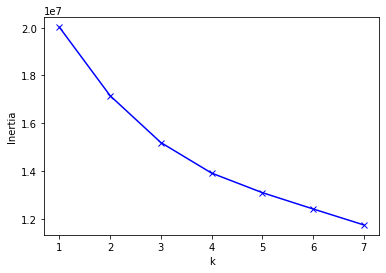

In [75]:
# Plot the elbow
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.show()

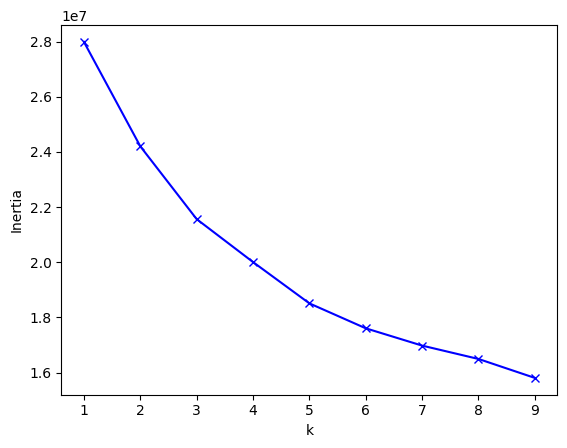

In [49]:
########################################################################
################### GRAPH WITH NO OUTLIERS FIXED #######################

In [76]:
print("Start time:",time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime()))

kmeans = KMeans(n_clusters=3).fit(data_scaled)
labels = pd.DataFrame(kmeans.labels_) #This is where the label output of the KMeans we just ran lives. Make it a dataframe so we can concatenate back to the original data

fixed_data_ind_reset = fixed_data.reset_index(drop=True)
data_scaled_ind_reset = pd.DataFrame(data_scaled).reset_index(drop=True)

labeledLoans = pd.concat((fixed_data_ind_reset,labels),axis=1)
labeledLoansScaled = pd.concat((data_scaled_ind_reset,labels),axis=1)

labeledLoans = labeledLoans.rename({0:'cluster'},axis=1)
labeledLoansScaled = labeledLoansScaled.rename({0:'cluster'},axis=1)

print("Done:",time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime()))

Start time: 2022-09-07 13:04:09
Done: 2022-09-07 13:04:43


In [77]:
def good_loans(data, cluster):
    return len(data[(data["y"] == 1) & (data["cluster"] == cluster)])

def bad_loans(data, cluster):
    return len(data[(data["y"] == 0) & (data["cluster"] == cluster)])

In [80]:
labeledLoans = labeledLoans.reset_index(drop=True)
data_save_y_and_id = data_save_y_and_id.reset_index(drop=True)

labeledLoans_clustered_full = pd.concat([labeledLoans, data_save_y_and_id], axis=1)
labeledLoans_clustered_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6384872 entries, 0 to 6384871
Data columns (total 41 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   amount_current_loan               float64
 1   yearly_income                     float64
 2   bankruptcies                      float64
 3   years_current_job                 float64
 4   monthly_debt                      float64
 5   years_credit_history              float64
 6   open_accounts                     float64
 7   credit_problems                   float64
 8   credit_balance                    float64
 9   max_open_credit                   float64
 10  term_long                         float64
 11  term_short                        float64
 12  credit_score_fair                 float64
 13  credit_score_good                 float64
 14  credit_score_unknown              float64
 15  credit_score_very_good            float64
 16  loan_purpose_business_loan        fl

In [82]:
print("Cluster 0:", good_loans(labeledLoans_clustered_full,0)/len(labeledLoans_clustered_full))
print("Cluster 1:", good_loans(labeledLoans_clustered_full,1)/len(labeledLoans_clustered_full))
print("Cluster 2:", good_loans(labeledLoans_clustered_full,2)/len(labeledLoans_clustered_full))

Cluster 0: 0.10201927305668775
Cluster 1: 0.08139364422654048
Cluster 2: 0.09063016455145852


<AxesSubplot:xlabel='amount_current_loan', ylabel='yearly_income'>

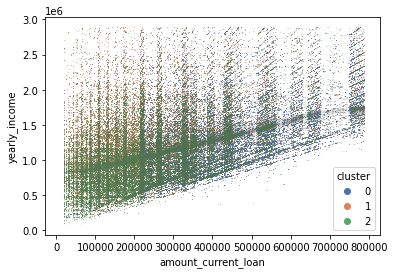

In [83]:
#sns.lmplot(x='amount_current_loan',y='yearly_income',data=labeledLoans,hue='cluster',fit_reg=False, scatter_kws={"s": 0.001})
sns.scatterplot(x='amount_current_loan',y='yearly_income',data=labeledLoans,hue='cluster',s=0.01,palette="deep")
#sns.pairplot(labeledLoans.loc[:,['amount_current_loan','yearly_income','cluster']],hue='cluster')

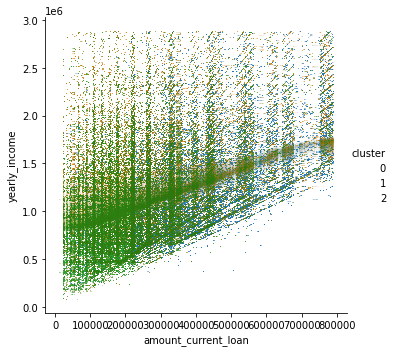

In [85]:
sns.lmplot(x='amount_current_loan',y='yearly_income',data=labeledLoans,hue='cluster',fit_reg=False, scatter_kws={"s": 0.0001})

##### Might make sense to make slices of data and looking into some statistics. To be expanded here....

###### PCA CLUSTERING

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

Sc = StandardScaler()
X = Sc.fit_transform(data_to_cluster)
print('Fitting PCA start:',time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime()))
pca = PCA(2) 
#pca_data = pd.DataFrame(pca.fit_transform(X),columns=['PC1','PC2', 'PC3', 'PC4'])
pca_data = pd.DataFrame(pca.fit_transform(X),columns=['PC1','PC2'])
print('Clustering start:',time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime()))
kmeans =KMeans(n_clusters=3).fit(X)
pca_data['cluster'] = pd.Categorical(kmeans.labels_)
print('Done!',time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime()))
pca_data.info()

Fitting PCA start: 2022-09-07 13:14:26
Clustering start: 2022-09-07 13:14:55
Done! 2022-09-07 13:15:39
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6384872 entries, 0 to 6384871
Data columns (total 3 columns):
 #   Column   Dtype   
---  ------   -----   
 0   PC1      float64 
 1   PC2      float64 
 2   cluster  category
dtypes: category(1), float64(2)
memory usage: 103.5 MB


<AxesSubplot:xlabel='PC1', ylabel='PC2'>

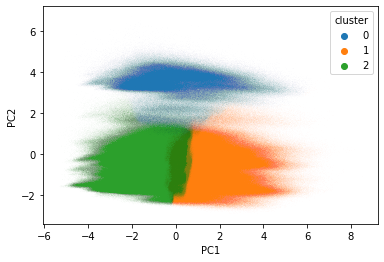

In [88]:
sns.scatterplot(x="PC1",y="PC2",hue="cluster",data=pca_data, s=0.01)

In [89]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

loading_matrix = pd.DataFrame(loadings, columns=['PC1', 'PC2'], index=data_to_cluster.columns)
loading_matrix.sort_values('PC1')

,PC1,PC2
term_short,-0.570339,0.170499
home_ownership_rent,-0.427473,-0.195139
loan_purpose_other,-0.257525,0.021610
bankruptcies,-0.109152,0.100729
credit_problems,-0.096268,0.128647
loan_purpose_buy_a_car,-0.087551,0.016036
credit_score_very_good,-0.083350,-0.010406
loan_purpose_take_a_trip,-0.073640,0.007020
delinquent_cat_Other,-0.068728,-0.628961
loan_purpose_vacation&purch&move,-0.067584,0.008883


In [90]:
merged_pca_clustered = pd.concat([fixed_data, pca_data, data_save_y_and_id], axis=1)
merged_pca_clustered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6384872 entries, 0 to 6384871
Data columns (total 43 columns):
 #   Column                            Dtype   
---  ------                            -----   
 0   amount_current_loan               float64 
 1   yearly_income                     float64 
 2   bankruptcies                      float64 
 3   years_current_job                 float64 
 4   monthly_debt                      float64 
 5   years_credit_history              float64 
 6   open_accounts                     float64 
 7   credit_problems                   float64 
 8   credit_balance                    float64 
 9   max_open_credit                   float64 
 10  term_long                         float64 
 11  term_short                        float64 
 12  credit_score_fair                 float64 
 13  credit_score_good                 float64 
 14  credit_score_unknown              float64 
 15  credit_score_very_good            float64 
 16  loan_purpose_busin

In [91]:
print("Cluster 0:", good_loans(merged_pca_clustered,0)/len(merged_pca_clustered), "(",len(merged_pca_clustered[merged_pca_clustered["cluster"] == 0])/len(fixed_data),")")
print("Cluster 1:", good_loans(merged_pca_clustered,1)/len(merged_pca_clustered), "(",len(merged_pca_clustered[merged_pca_clustered["cluster"] == 1])/len(fixed_data),")")
print("Cluster 2:", good_loans(merged_pca_clustered,2)/len(merged_pca_clustered), "(",len(merged_pca_clustered[merged_pca_clustered["cluster"] == 2])/len(fixed_data),")")

Cluster 0: 0.051291866148608777 ( 0.1338147420966309 )
Cluster 1: 0.10106874499598426 ( 0.35456920671236636 )
Cluster 2: 0.1216824706900937 ( 0.5116160511910027 )


<AxesSubplot:xlabel='PC1', ylabel='PC2'>

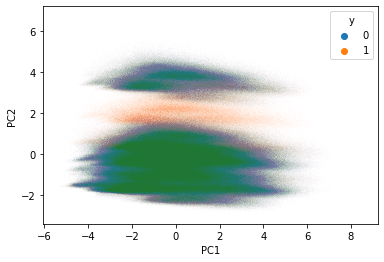

In [92]:
sns.scatterplot(x="PC1",y="PC2",hue="y",data=merged_pca_clustered, s=0.01)

### To be continued!

In [94]:
# #data_chunk = labeledLoans[labeledLoans['amount_current_loan'] < 5000000]
# # data_chunk = labeledLoans
# sns.lmplot(x='amount_current_loan',y='monthly_debt',data=data_chunk[data_chunk['cluster'] == 0],hue='y',fit_reg=False, scatter_kws={"s": 0.05})
# sns.lmplot(x='amount_current_loan',y='monthly_debt',data=data_chunk[data_chunk['cluster'] == 1],hue='y',fit_reg=False, scatter_kws={"s": 0.05})
# sns.lmplot(x='amount_current_loan',y='monthly_debt',data=data_chunk[data_chunk['cluster'] == 2],hue='y',fit_reg=False, scatter_kws={"s": 0.05})

# #sns.lmplot(x='amount_current_loan',y='monthly_debt',data=data_chunk[data_chunk['amount_current_loan'] < 5000000],hue='cluster',fit_reg=False, scatter_kws={"s": 0.05})

In [93]:
#sns.lmplot(x='amount_current_loan',y='monthly_debt',data=data_chunk[data_chunk['cluster'] == 0],hue='y',fit_reg=False, scatter_kws={"s": 0.01})
#sns.lmplot(x='amount_current_loan',y='monthly_debt',data=data_chunk[data_chunk['cluster'] == 1],hue='y',fit_reg=False, scatter_kws={"s": 0.01})
#sns.lmplot(x='amount_current_loan',y='monthly_debt',data=data_chunk[data_chunk['cluster'] == 2],hue='y',fit_reg=False, scatter_kws={"s": 0.01})
#sns.lmplot(x='amount_current_loan',y='max_open_credit',data=data_chunk,hue='cluster',fit_reg=False, scatter_kws={"s": 0.05})
#max_open_credit

### FUZZY CLUSTERING

In [ ]:
# Number of Clusters
k = 3
# Maximum number of iterations
MAX_ITER = 100
# Number of data points
n = len(df)
# Fuzzy parameter
m = 1.7 #Select a value greater than 1 else it will be knn